# Импорт необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
import warnings
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torchvision.datasets as datasets
import torchvision.transforms as transforms


%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
random.seed(42)

# Создадим набор данных для обучения

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True)
test = datasets.MNIST(root='./data', train=False, download=True)

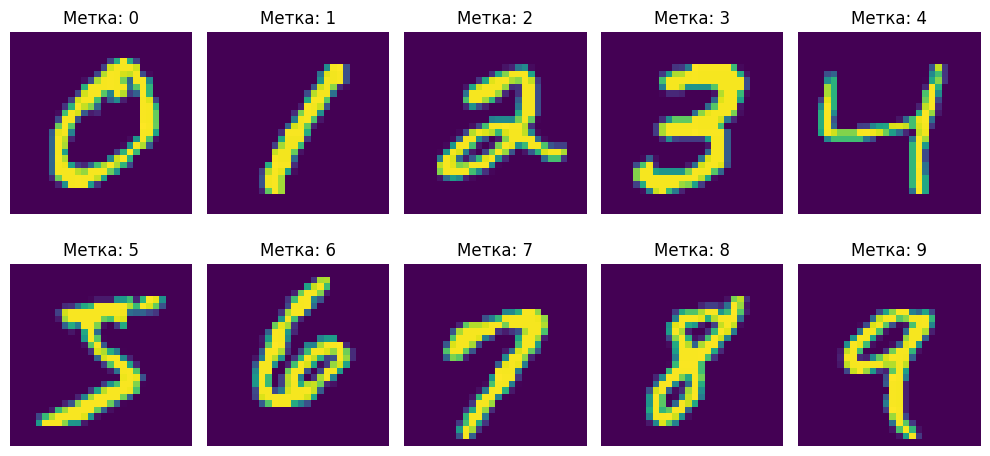

In [3]:
unique_labels = np.unique(train.targets.numpy())

plt.figure(figsize=(10, 5))
for i, label in enumerate(unique_labels[:10]):
    indices = np.where(train.targets.numpy() == label)[0]
    image = train.data[indices[0]].numpy()
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='viridis')
    plt.title(f"Метка: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
class TripletDataset(Dataset):
    def __init__(self, dataset: datasets.MNIST, describe: str, train=True):
        self.is_train = train
        self.describe = describe
    
        self.labels = dataset.targets.numpy()
        self.values = dataset.data.numpy()

        self.transform = transforms.ToTensor()

        if self.is_train:
            self.triplets = self.generate_triplets()
        else:
            self.triplets = []

    def generate_triplets(self):
        label_to_indices = {label: np.where(self.labels == label)[0] for label in np.unique(self.labels)}
        
        triplets = []
        
        for anchor_idx in tqdm(range(len(self.labels)), desc=self.describe):
            anchor_label = self.labels[anchor_idx]
            
            positive_indices = label_to_indices[anchor_label]
            positive_indices = positive_indices[positive_indices != anchor_idx]
            
            negative_indices = np.where(self.labels != anchor_label)[0]
            
            if positive_indices.size > 0 and negative_indices.size > 0:
                positive_idx = random.choice(positive_indices)
                negative_idx = random.choice(negative_indices)
                triplets.append((anchor_idx, positive_idx, negative_idx))

        return triplets

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        if self.is_train:
            anchor_idx, positive_idx, negative_idx = self.triplets[idx]
            anchor = self.values[anchor_idx]
            positive = self.values[positive_idx]
            negative = self.values[negative_idx]

            return self.transform(anchor), self.transform(positive), self.transform(negative), self.labels[anchor_idx]
        else:
            anchor_idx = idx
            anchor = self.values[anchor_idx]
            return self.transform(anchor), self.labels[anchor_idx]

In [5]:
triplet_train = TripletDataset(train, 'Генерация троек для обучения', train=True)
triplet_test = TripletDataset(test, 'Генерация троек для теста', train=True)

Генерация троек для обучения:   0%|          | 0/60000 [00:00<?, ?it/s]

Генерация троек для теста:   0%|          | 0/10000 [00:00<?, ?it/s]

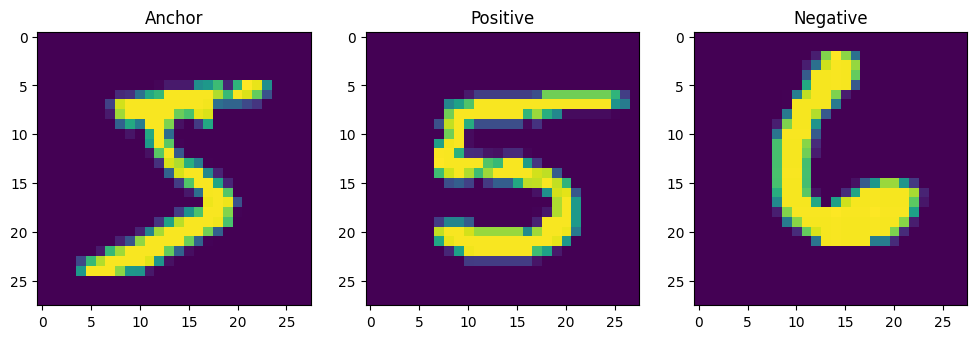

In [6]:
anchor, positive, negative, label = triplet_train[0]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(anchor.squeeze(), cmap='viridis')
axes[0].set_title('Anchor')

axes[1].imshow(positive.squeeze(), cmap='viridis')
axes[1].set_title('Positive')

axes[2].imshow(negative.squeeze(), cmap='viridis')
axes[2].set_title('Negative')

plt.show()

In [7]:
train_loader = DataLoader(triplet_train, batch_size=32, shuffle=True)
test_loader = DataLoader(triplet_test, batch_size=32, shuffle=False)

# Объявим нужные классы для обучения модели

In [8]:
class EarlyStopping:
    def __init__(self, model_path, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.path = model_path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            model.save_model(self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

In [9]:
class TripletNN(nn.Module):
    def __init__(self, patience, model_path, output_dim) -> None:
        super(TripletNN, self, ).__init__()
        self.linear_layers = nn.ModuleList()
        self.convolutional_layers = nn.ModuleList()

        self.convolutional_params = [(16, 2, 1), (32, 3, 2), (1, 1, 1)]
        self.linear_params = [256, output_dim]

        self.early_stopping = EarlyStopping(model_path=model_path, patience=patience, verbose=True)

        for params in self.convolutional_params:
            channels, kernel, stride = params
            if params != self.convolutional_params[-1]:
                self.convolutional_layers.append(nn.LazyConv2d(out_channels=channels, kernel_size=kernel, stride=stride))
                self.convolutional_layers.append(nn.Dropout2d(p=0.5))
                self.convolutional_layers.append(nn.LazyBatchNorm2d())
                self.convolutional_layers.append(nn.RReLU())
            else:
                self.convolutional_layers.append(nn.MaxPool2d(kernel_size=2))
                self.convolutional_layers.append(nn.Flatten())
                self.convolutional_layers.append(nn.LeakyReLU())

        for out in self.linear_params:
            if out != self.linear_params[-1]:
                self.linear_layers.append(nn.LazyLinear(out_features=out))
                self.linear_layers.append(nn.Dropout1d(p=0.5))
                self.linear_layers.append(nn.LazyBatchNorm1d())
                self.linear_layers.append(nn.LeakyReLU())
            else:
                self.linear_layers.append(nn.LazyLinear(out_features=out))

        self.train_loss_history = []
        self.valid_loss_history = []


    def forward(self, x):
        for conv_layer in self.convolutional_layers:
            x = conv_layer(x)

        for layer in self.linear_layers:
            x = layer(x)
        return x


    def fit(self, train_loader: DataLoader, valid_loader: DataLoader, nepochs: int = 100,
            device: torch.device = torch.device('cuda'), lr: float = 1e-2):

        self.optim = torch.optim.Adam(self.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', factor=0.5, patience=3)

        self.train().to(device)
        criterion = nn.TripletMarginLoss(margin=1.5)

        for g in self.optim.param_groups:
            g['lr'] = lr

        for ep in tqdm(range(nepochs), desc='Epoch'):
            for anchor, positive, negative, _ in train_loader:
                self.optim.zero_grad()

                anchor_pred = self.forward(anchor.to(device))
                positive_pred = self.forward(positive.to(device))
                negative_pred = self.forward(negative.to(device))

                loss = criterion(anchor_pred, positive_pred, negative_pred)

                loss.backward()
                self.optim.step()

            self.train_loss_history.append(self.calc_loss(train_loader, device=device).mean())
            self.valid_loss_history.append(self.calc_loss(valid_loader, device=device).mean())

            print_loss_bool = (ep+1) % 10 == 0 if nepochs > 10 else True
            if print_loss_bool:
                print(f'Train loss: {self.train_loss_history[-1]:.5f}')
                print(f'Valid loss: {self.valid_loss_history[-1]:.5f}')
                print(f'Learning rate: {self.optim.param_groups[0]["lr"]:.5f}\n')

            self.scheduler.step(self.valid_loss_history[-1])
            self.early_stopping(self.valid_loss_history[-1], self)

            if self.early_stopping.early_stop:
                break


    def extract_embeddings_and_labels(self, data_loader: DataLoader, device: torch.device):
        self.eval()
        embeddings = []
        labels = []

        with torch.no_grad():
            for batch in data_loader:
                if len(batch) == 4:
                    anchor, _p, _n, label = batch
                else:
                    anchor, label = batch

                anchor_pred = self(anchor.to(device)).cpu().numpy()
                embeddings.append(anchor_pred)
                labels.extend(label.numpy())

        embeddings = np.concatenate(embeddings)
        labels = np.array(labels)

        return embeddings, labels


    def calc_loss(self, data_loader: DataLoader, device: torch.device) -> torch.Tensor:
        self.eval().to(device)
        criterion = nn.TripletMarginLoss(reduction='none', margin=1.5)
        losses = []
        with torch.no_grad():
            for anchor, positive, negative, _ in data_loader:
                anchor_pred = self.forward(anchor.to(device))
                positive_pred = self.forward(positive.to(device))
                negative_pred = self.forward(negative.to(device))

                batch_loss = criterion(anchor_pred, positive_pred, negative_pred)
                losses.append(batch_loss.cpu())

        return torch.cat(losses)


    def plot_loss(self):
        loss_values_train = [loss.item() for loss in self.train_loss_history]
        loss_values_val = [loss.item() for loss in self.valid_loss_history]

        plt.figure(figsize=(24, 12))

        plt.plot(loss_values_train, marker='o', linestyle='-', color='b', label='Training Loss')
        plt.plot(loss_values_val, marker='o', linestyle='-', color='r', label='Validation Loss')

        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


    def save_model(self, path: str):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'train_loss_history': self.train_loss_history,
            'valid_loss_history': self.valid_loss_history,
        }
        torch.save(checkpoint, path)


    def load_model(self, path: str):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])

        self.train_loss_history = checkpoint['train_loss_history']
        self.valid_loss_history = checkpoint['valid_loss_history']

# Обучим модель для двумерных эмбеддингов

In [10]:
model = TripletNN(patience=5, model_path='2dmodel.pth', output_dim=2)
model.fit(train_loader, test_loader, nepochs=30, device=device, lr=1e-4)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.03109
Valid loss: 0.07773
Learning rate: 0.00010

Train loss: 0.00437
Valid loss: 0.06271
Learning rate: 0.00005

Early stopping triggered.


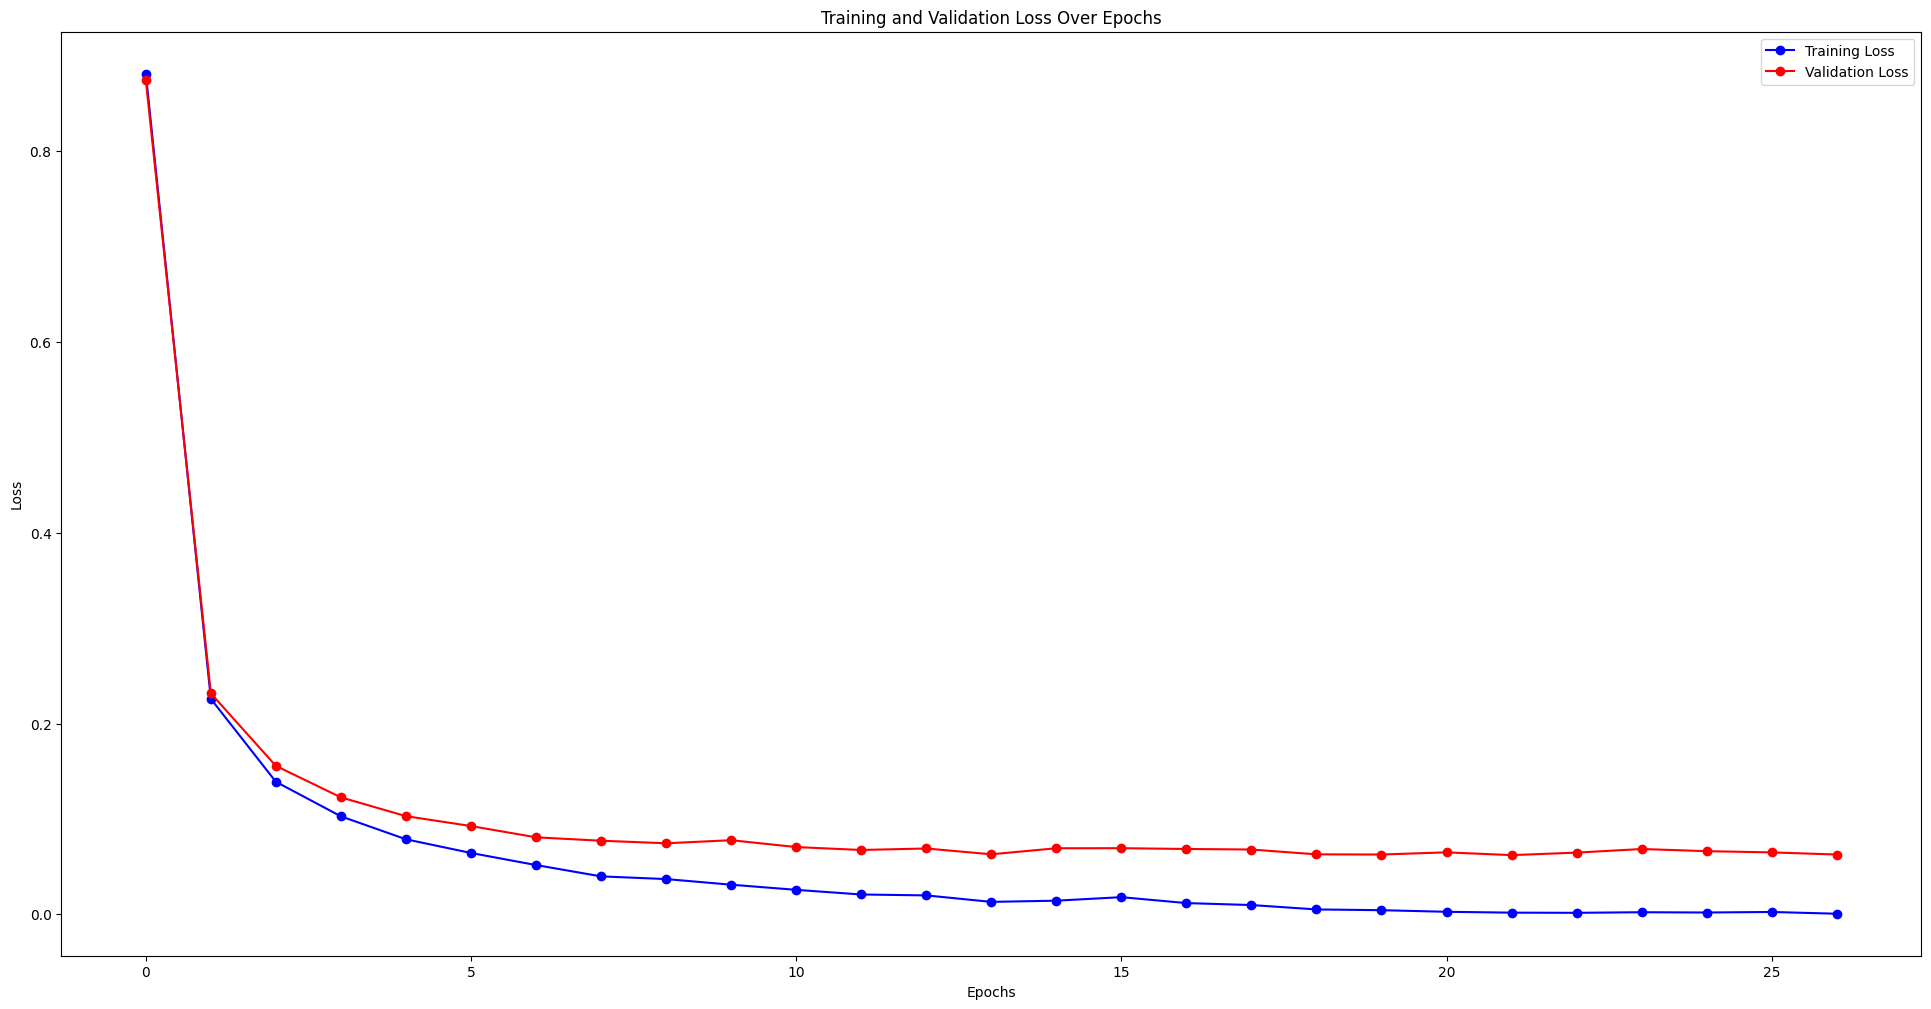

In [11]:
model.plot_loss()

In [12]:
embeddings, labels = model.extract_embeddings_and_labels(train_loader, device)

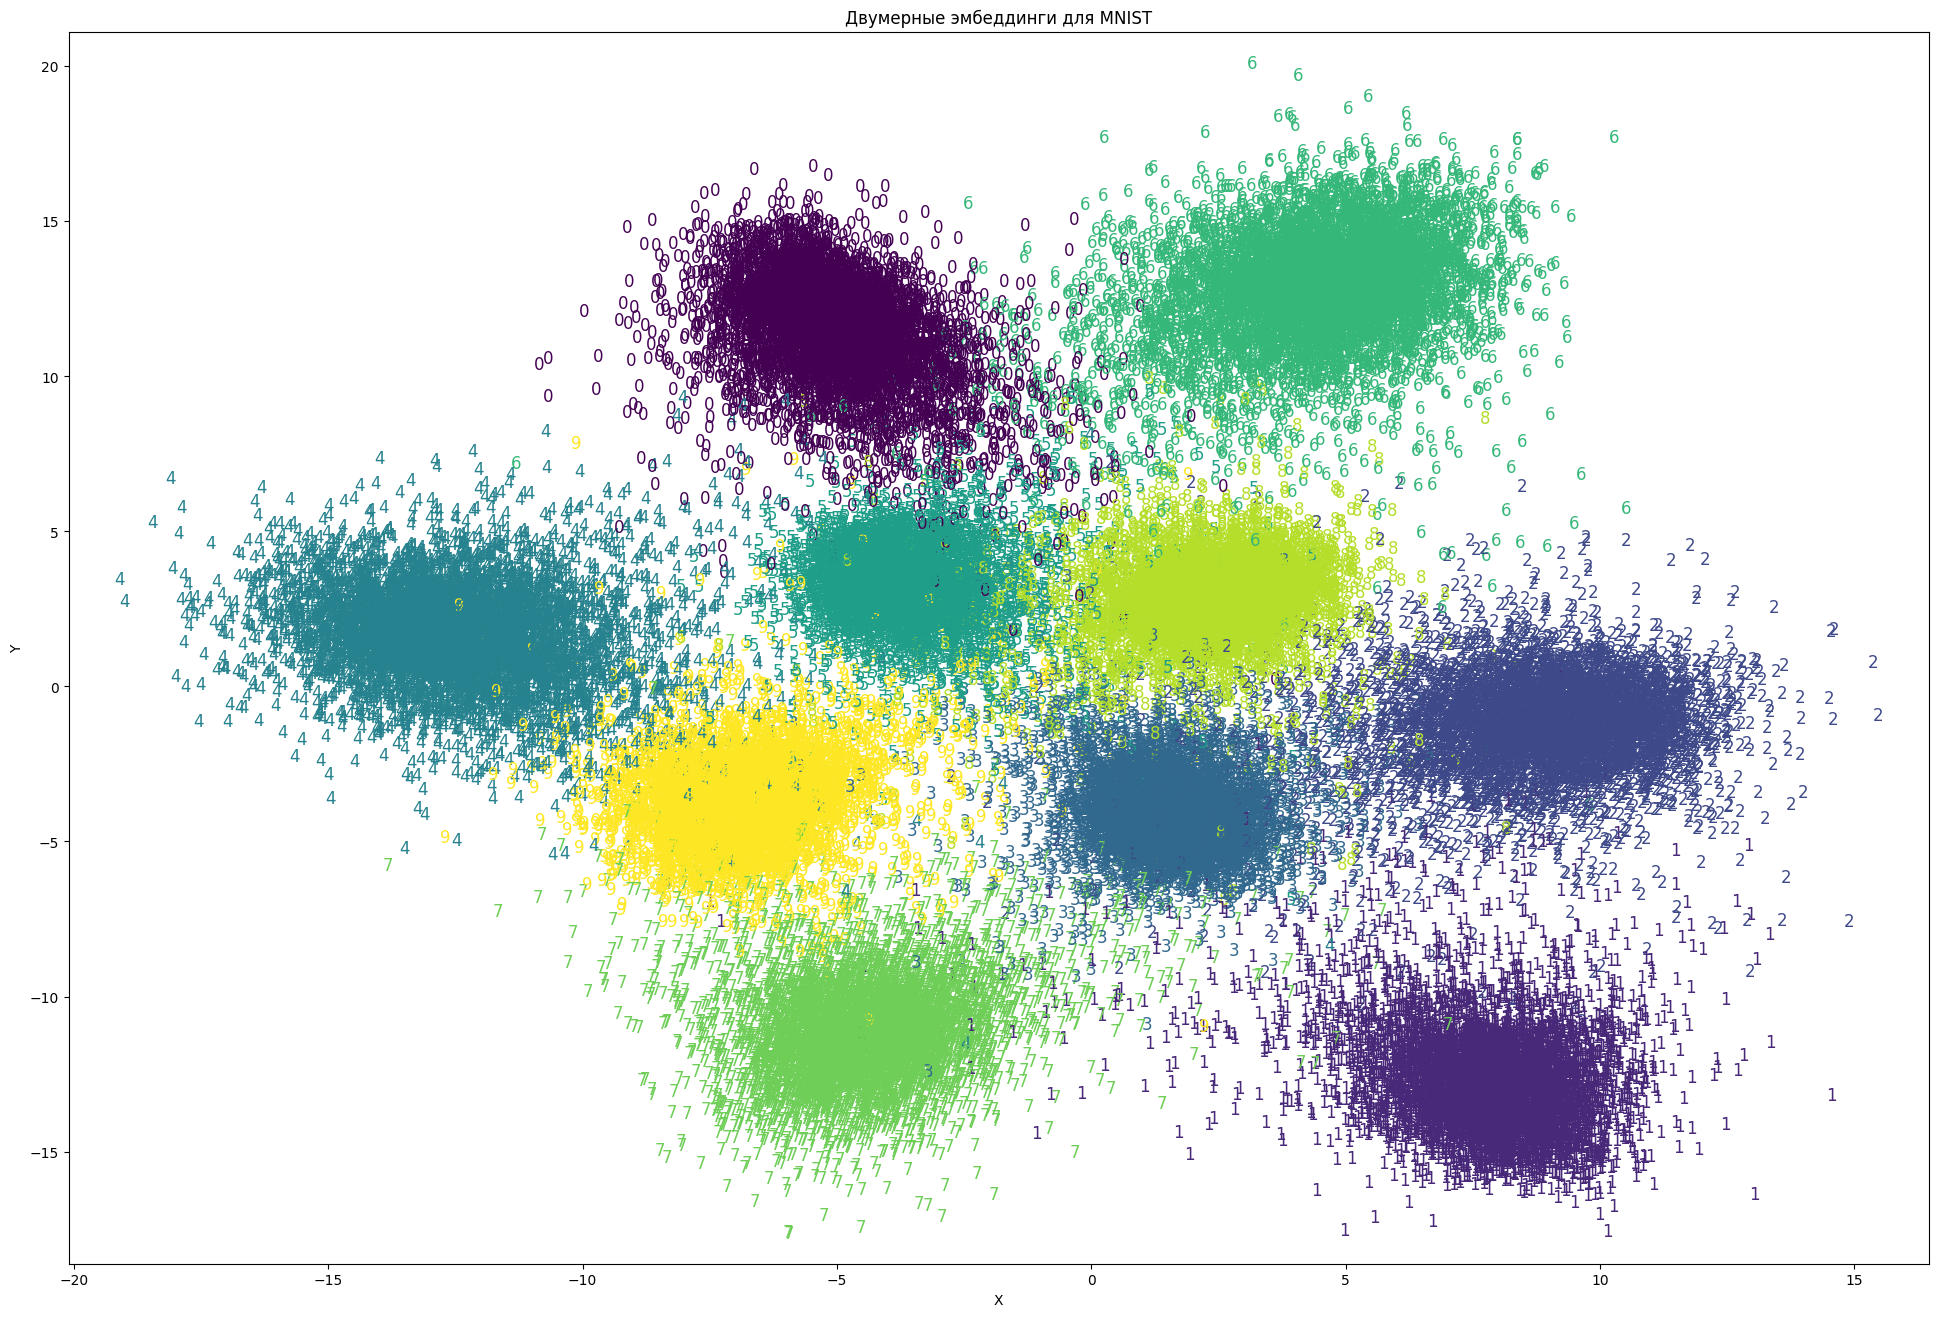

In [13]:
plt.figure(figsize=(24, 16))

colors = plt.cm.get_cmap('viridis', 10)

for i in range(len(embeddings)):
    plt.text(embeddings[i, 0], embeddings[i, 1], str(labels[i]), 
             fontsize=12, ha='center', va='center', 
             color=colors(labels[i]))

plt.title('Двумерные эмбеддинги для MNIST')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(np.min(embeddings[:, 0]) - 1, np.max(embeddings[:, 0]) + 1)
plt.ylim(np.min(embeddings[:, 1]) - 1, np.max(embeddings[:, 1]) + 1)
plt.show()

In [14]:
embeddings, labels = model.extract_embeddings_and_labels(test_loader, device)

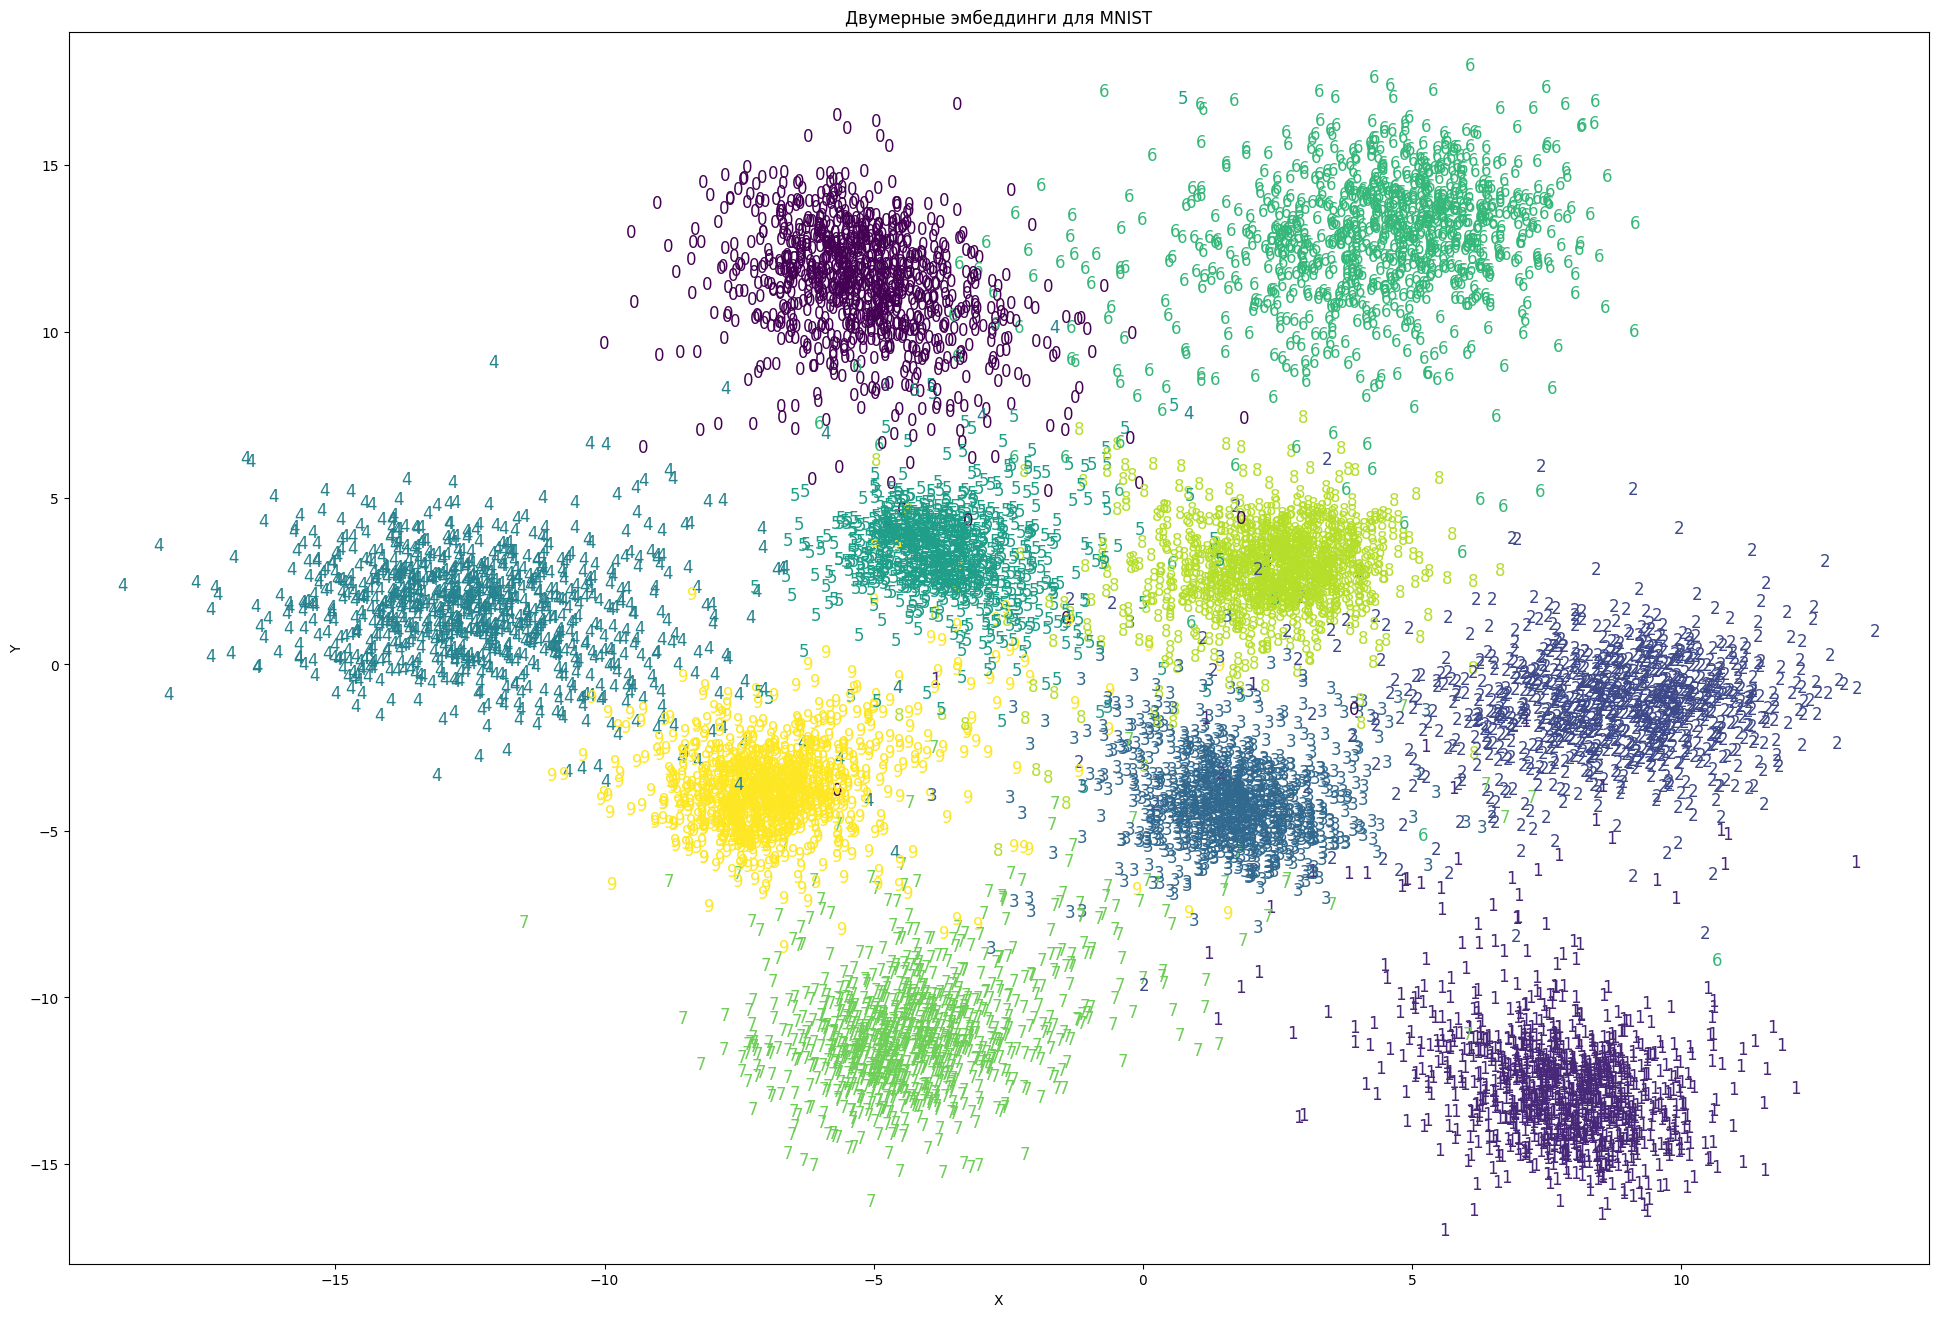

In [15]:
plt.figure(figsize=(24, 16))
colors = plt.cm.get_cmap('viridis', 10)

for i in range(len(embeddings)):
    plt.text(embeddings[i, 0], embeddings[i, 1], str(labels[i]), 
             fontsize=12, ha='center', va='center', 
             color=colors(labels[i]))

plt.title('Двумерные эмбеддинги для MNIST')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(np.min(embeddings[:, 0]) - 1, np.max(embeddings[:, 0]) + 1)
plt.ylim(np.min(embeddings[:, 1]) - 1, np.max(embeddings[:, 1]) + 1)
plt.show()

Теперь когда мы создали модель, которая обучается на триплетах. Теперь создадим экземпляр модери, которая будет формировать эмбеддинги большей размерности чем два. Зачем? просто интересно, возможно репрезентация на многомерное пространство будет лучше. 

# Обучим модель триплетов на создание эмбеддингов размерности 64, после чего обучим многоклассовую модель классификации на эмбеддингах

In [16]:
embedding_model = TripletNN(8, model_path='64dmodel.pth', output_dim=64)
embedding_model.fit(train_loader, test_loader, nepochs=50, device=device, lr=1e-4)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.00326
Valid loss: 0.02750
Learning rate: 0.00010

Train loss: 0.00026
Valid loss: 0.02549
Learning rate: 0.00005

Early stopping triggered.


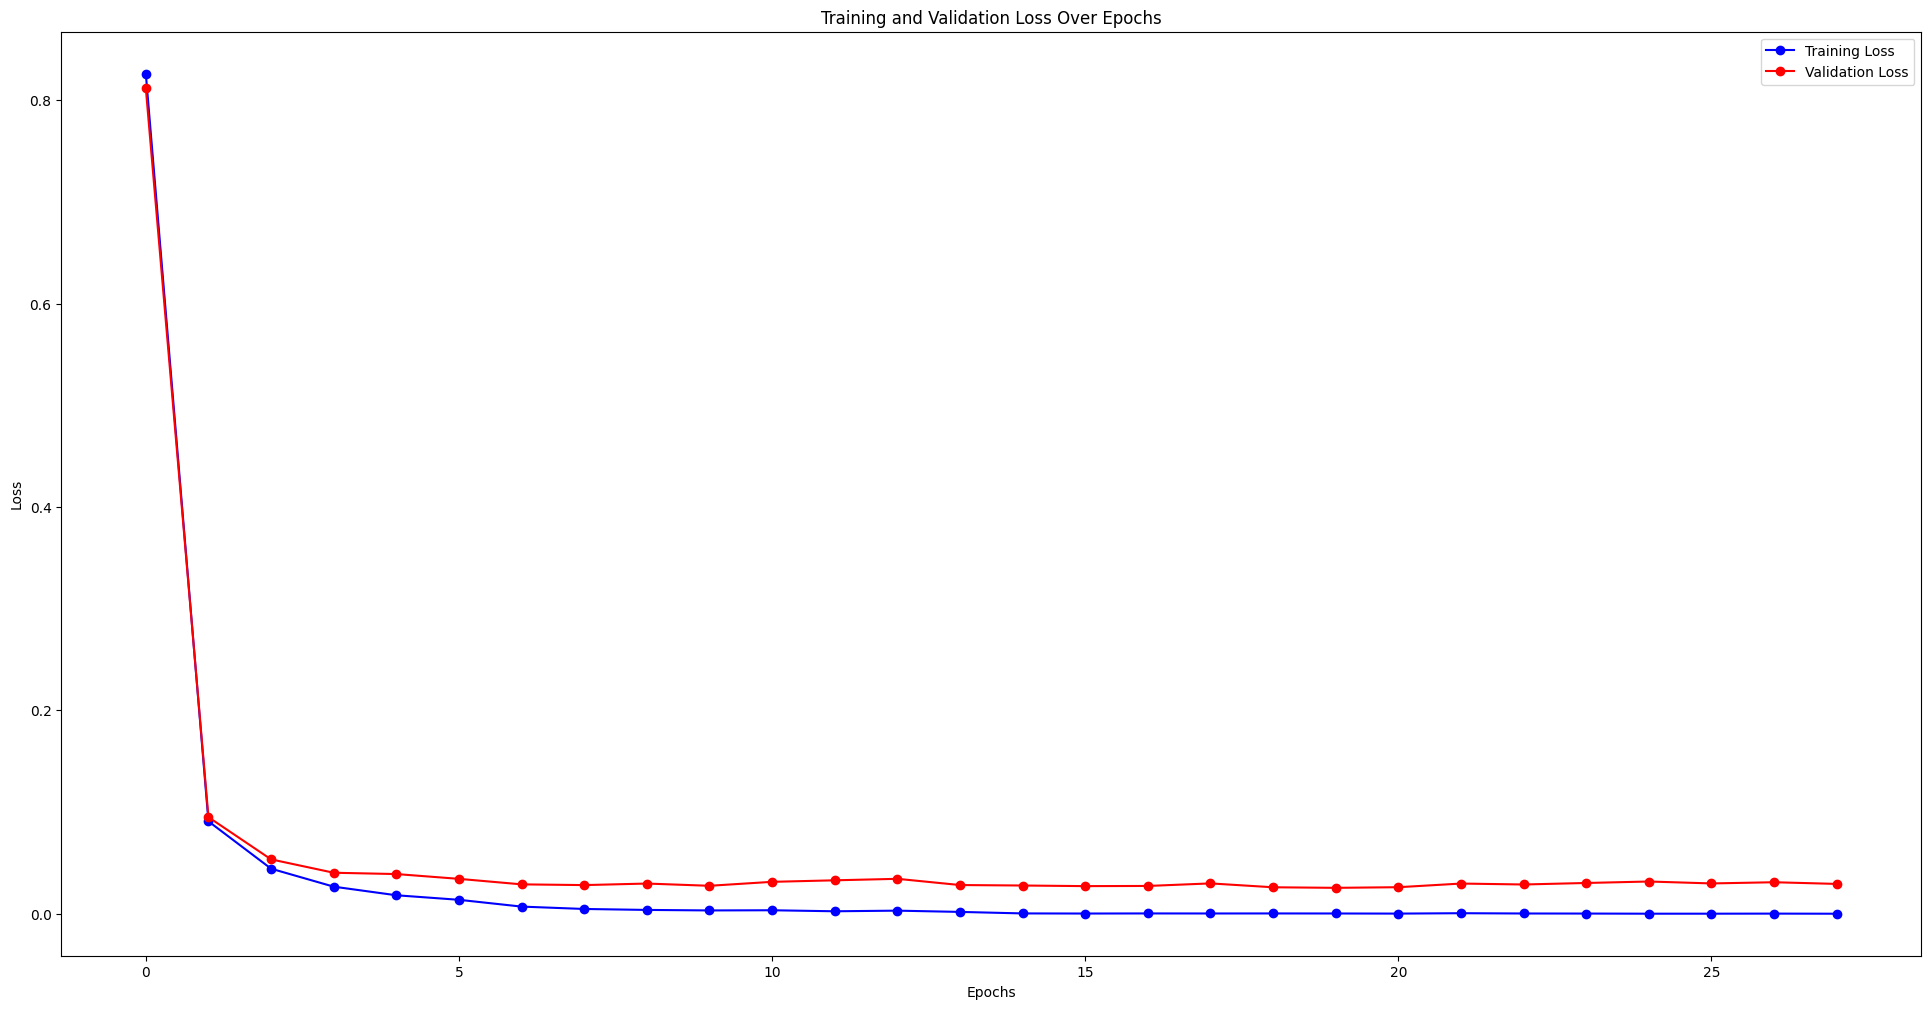

In [17]:
embedding_model.plot_loss()

In [18]:
train_embeddings, train_labels = embedding_model.extract_embeddings_and_labels(train_loader, device)
test_embeddings, test_labels = embedding_model.extract_embeddings_and_labels(test_loader, device)

In [19]:
train_tensor = TensorDataset(torch.tensor(train_embeddings), torch.tensor(train_labels))
test_tensor = TensorDataset(torch.tensor(test_embeddings), torch.tensor(test_labels))

train_loader = DataLoader(train_tensor, batch_size=32, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=32, shuffle=False)

In [20]:
class MulticlassClassifier(nn.Module):
    def __init__(self, num_classes, model_path, patience):
        super(MulticlassClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.LazyLinear(48),
            nn.Dropout(),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            
            nn.LazyLinear(24),
            nn.Dropout(),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            
            nn.LazyLinear(num_classes)
        )

        self.early_stopping = EarlyStopping(model_path=model_path, patience=patience, verbose=True)

        self.train_loss_history = []
        self.valid_loss_history = []


    def forward(self, x):
        out = self.layers(x)
        return out
    

    def fit(self, train_loader: DataLoader, valid_loader: DataLoader, nepochs: int = 100,
            device: torch.device = torch.device('cuda'), lr: float = 1e-2):

        self.optim = torch.optim.Adam(self.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', factor=0.5, patience=3)

        self.train().to(device)
        criterion = nn.CrossEntropyLoss()

        for g in self.optim.param_groups:
            g['lr'] = lr

        for ep in tqdm(range(nepochs), desc='Epoch'):
            for values, labels in tqdm(train_loader, desc='Batch'):
                self.optim.zero_grad()

                outputs = self.forward(values.to(device))

                loss = criterion(outputs, labels.to(device))

                loss.backward()
                self.optim.step()

            self.train_loss_history.append(self.calc_loss(train_loader, device=device).mean())
            self.valid_loss_history.append(self.calc_loss(valid_loader, device=device).mean())

            print_loss_bool = (ep+1) % 10 == 0 if nepochs > 10 else True
            if print_loss_bool:
                print(f'Train loss: {self.train_loss_history[-1]:.5f}')
                print(f'Valid loss: {self.valid_loss_history[-1]:.5f}')
                print(f'Learning rate: {self.optim.param_groups[0]["lr"]:.5f}\n')

            self.scheduler.step(self.valid_loss_history[-1])
            self.early_stopping(self.valid_loss_history[-1], self)

            if self.early_stopping.early_stop:
                break


    def get_predictions(self, data_loader, device):
        self.eval().to(device)
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for values, labels in data_loader:
                outputs = self.forward(values.to(device))
                _, predicted_classes = torch.max(outputs, dim=1)

                all_predictions.append(predicted_classes.cpu())
                all_labels.append(labels.cpu())

        all_predictions = torch.cat(all_predictions)
        all_labels = torch.cat(all_labels)

        return all_predictions, all_labels 


    def calc_loss(self, data_loader: DataLoader, device: torch.device) -> torch.Tensor:
        self.eval().to(device)
        criterion = nn.CrossEntropyLoss(reduction='none')
        losses = []
        with torch.no_grad():
            for values, labels in data_loader:
                output = self.forward(values.to(device))
                batch_loss = criterion(output, labels.to(device))
                losses.append(batch_loss.cpu())

        return torch.cat(losses)


    def plot_loss(self):
        loss_values_train = [loss.item() for loss in self.train_loss_history]
        loss_values_val = [loss.item() for loss in self.valid_loss_history]

        plt.figure(figsize=(24, 12))

        plt.plot(loss_values_train, marker='o', linestyle='-', color='b', label='Training Loss')
        plt.plot(loss_values_val, marker='o', linestyle='-', color='r', label='Validation Loss')

        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


    def save_model(self, path: str):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'train_loss_history': self.train_loss_history,
            'valid_loss_history': self.valid_loss_history,
        }
        torch.save(checkpoint, path)


    def load_model(self, path: str):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])

        self.train_loss_history = checkpoint['train_loss_history']
        self.valid_loss_history = checkpoint['valid_loss_history']

In [21]:
classifier = MulticlassClassifier(num_classes=10, model_path='classifier.pth', patience=10)
classifier.fit(train_loader, test_loader, nepochs=100, device=device, lr=5e-4)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03681
Valid loss: 0.04460
Learning rate: 0.00050



Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03187
Valid loss: 0.04233
Learning rate: 0.00025



Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02862
Valid loss: 0.04149
Learning rate: 0.00013



Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Early stopping triggered.


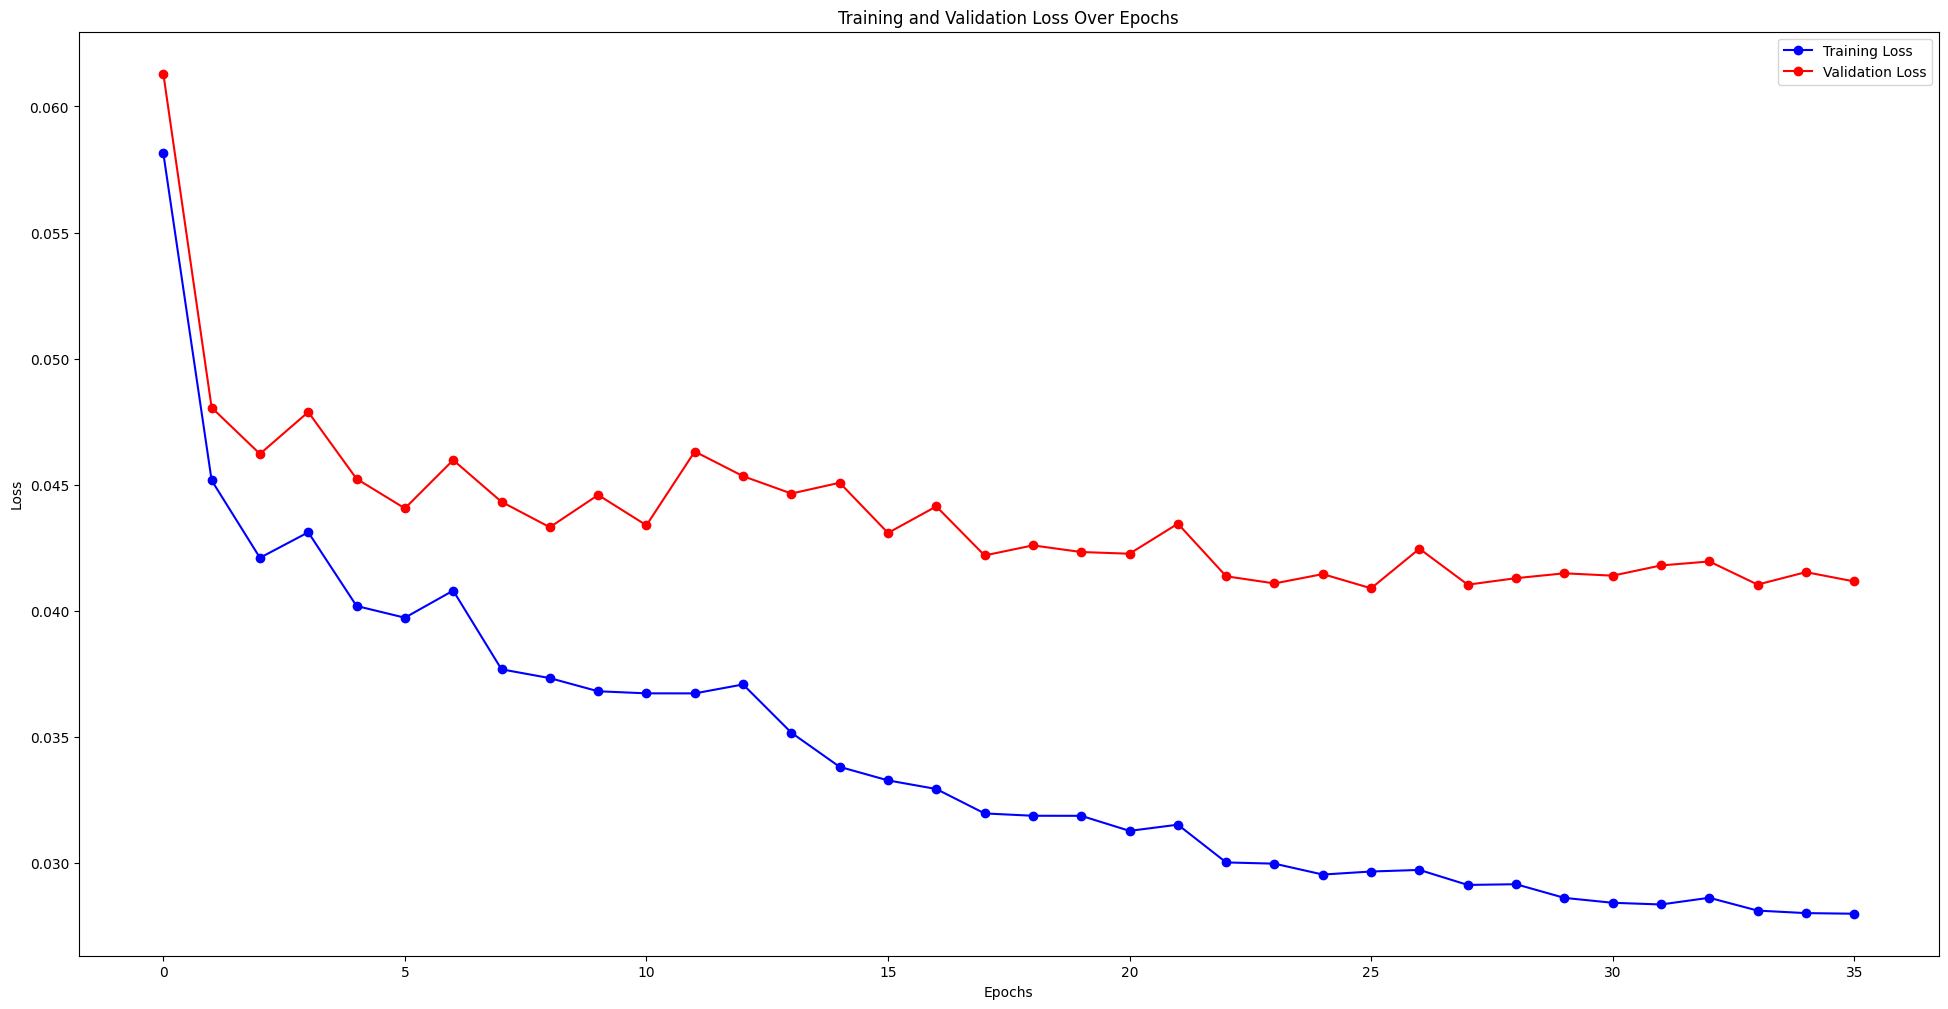

In [22]:
classifier.plot_loss()

In [23]:
preds, labels = classifier.get_predictions(test_loader, device=device)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



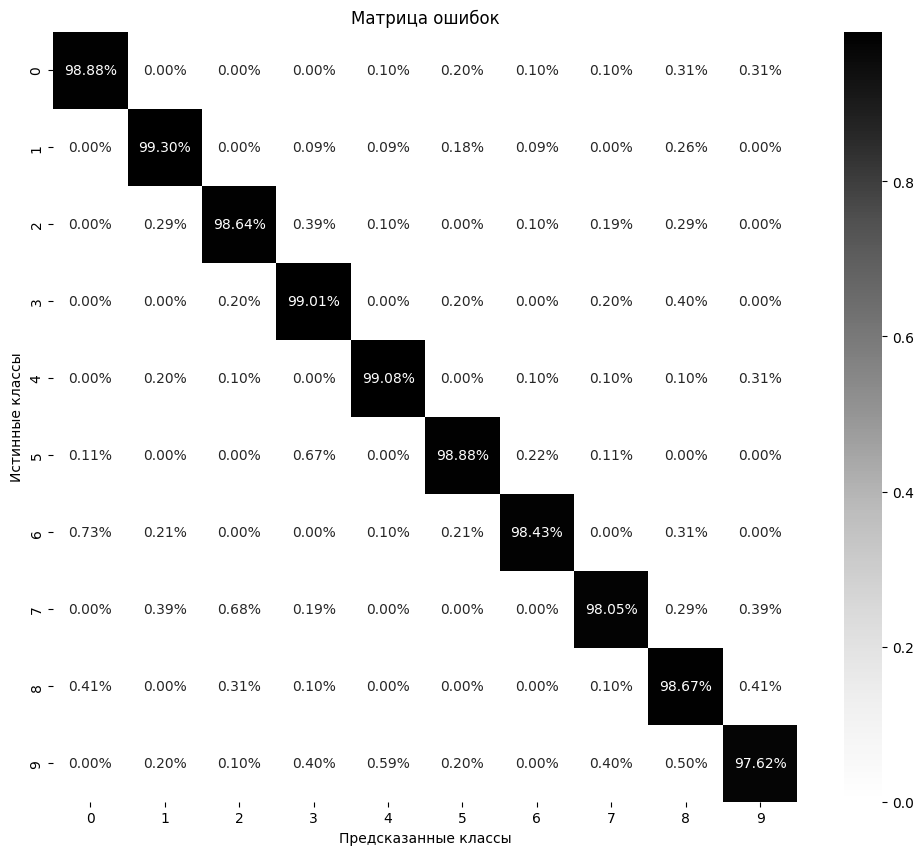

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Greys")
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()